# VQE for LiH molecule Simulation 


### Importing required files

In this notebook, I will simulate (Lithium Hydride)LiH molecule to find its ground state using the STO-3G basis with the PySCF driver and ParityMapper mapping.
Necessary files rquired for calculating the ground state energy of the molecule are imported in the below cell

In [1]:
# Importing necessary files required for the algorithm

from qiskit_nature.drivers import PySCFDriver
from qiskit import Aer
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD, UCC, UVCCSD
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit import Aer
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.aqua.operators.gradients import Gradient
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import matplotlib.pyplot as plt
import numpy as np 

### Setting the backend

Setting backend to statevector simulator. This algorithm can also be executed on actual Quantum Computer instead of a simulator.

In [2]:
backend = Aer.get_backend('statevector_simulator')

### Defining a Driver

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers.
There are various drivers available in qiskit, for example `PSI4Driver`, `PyQuanteDriver`, `PySCFDriver`. We will be using PySCFDriver.  

By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [3]:
# Defining the geometry of the LiH molecule
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
Qmolecule = driver.run()
qmolecule = FreezeCoreTransformer().transform(Qmolecule)

### Electronic Structure Problem

Below cell creates an `ElectronicStructureProblem` that produces the list of fermionic operators before mapping them to qubits (Pauli strings).
Along with this, corefreezing and orbital removal is used to reduce the number of qubits for constructing the ansatz. The orbitals which do not contribute to the optjmization or their contribution is less can be removed using `remove_orbitals` parameter in `ElectronicStructureProblem`.  

In [4]:
problem = ElectronicStructureProblem(driver,q_molecule_transformers=
                                     [FreezeCoreTransformer(freeze_core=True,remove_orbitals=[3,4])])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

### Setting a Mapper

Below cell allows to define the mapping that is used in the simulation. Along with Parity Mapper, other mapping are allowed in qiskit_nature. They are Jordan Wigner and Bravy Kitaev mapper.
But for this algorithm, Parity mapper is used as only ParityMapper supports `Two Qubit Reduction`. Which is also using in this algorithm for reducing the number of qubits in the Ansatz.

In [5]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[-1,1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

### Initial state
A good initial state in chemistry is the HF state (i.e. $|\Psi_{HF} \rangle = |0101 \rangle$). It is initialized as follows:

In [6]:
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


### Ansatz
Ansatz is one of the most important choices is the quantum circuit that is choosen to approximate the ground state of the molecule.
There are numerous predefined ansatzs in qiskit. Furthermore, custom ansatz can also be used. There are various options of ansatz which can be implemented. Changing the `ansatz_type` variable name to the suitable circuit changes the ansatz which is to be used for the algorithm. 

Ansatz used for the algorithm is displayed below : 


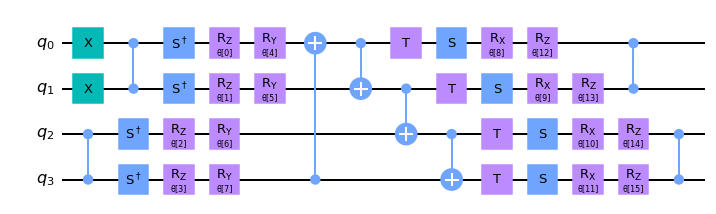

In [7]:
# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['sdg','rz','ry','cx','t','s','rx','rz']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'sca'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, entanglement_blocks, rotation_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)

print("Ansatz used for the algorithm is displayed below : ")
ansatz.draw('mpl')

### Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU.
A clever choice might reduce drastically the number of needed energy evaluations. Various options are available for Optimizer. Here, I have used `COBYLA` with maximum iterations of 3000, for optimization purpose. 

In [8]:
optimizer_type = 'COBYLA'
 
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=3000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=1500)

### Exact eigensolver

The exact electronic ground state energy can be found out with the exact diagonalization of the Hamiltonian matrix. This ground state energy is then later compared with the outcome of VQE algorithm. 
Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so it can be done for a large molecule of any choice as it becomes really difficult for solving the problem due to increase in the size. 
For very large systems you would run out of memory trying to store their wavefunctions.

In [9]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])

### VQE and initial parameters for the ansatz

In the below cell the VQE class is imported and the algorithm is executed. 
Initial parameters are all set to `0.01`. 

In [10]:
# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point,
                gradient=Gradient(grad_method='fin_diff'))

result = algorithm.compute_minimum_eigenvalue(qubit_op)

#print(result)

'Evaluation: 3000, Energy: -1.0861115322782675, Std: 0.0'

### Results

The Electronic and Calculated Ground state energy for Lithium Hydride molecule is shown in the below cell. Also, the cell represents graphs for Energy VS Iterations.

Exact electronic ground state energy for Lithium Hydride is : -1.08871
Calculated ground state energy for Lithium Hydride using VQE is : -1.08611
Percentage Error in calculating Ground state energy is : 0.24%


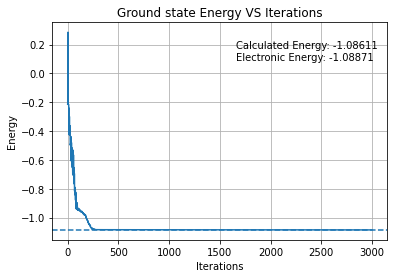

In [11]:
# Plot the results
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.55, 0.75, f'Calculated Energy: {result.optimal_value:.5f}\nElectronic Energy: {exact_energy:.5f}')
plt.title("Ground state Energy VS Iterations")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')

print(f'Exact electronic ground state energy for Lithium Hydride is : {exact_energy:.5f}')
print(f'Calculated ground state energy for Lithium Hydride using VQE is : {result.optimal_value:.5f}')
Error = abs((exact_energy-result.optimal_value)/exact_energy*100)
print(f'Percentage Error in calculating Ground state energy is : {Error:.2f}%')